In [1]:
import os, sys
sys.path.append("/home/alexanderalbizu")
sys.path.append("/home/alexanderalbizu/.local/bin")
os.environ["WANDB_NOTEBOOK_NAME"] = "CNN.ipynb"
#!python setup.py develop 
# !pip install wandb
# !pip install 'monai[all]'
#!pip -q install vit_pytorch
#!pip -q install linformer

In [2]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import glob, math, os, shutil, tempfile, time, monai, torch, random

import wandb as wb
from enum import Enum
import pandas as pd
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from monai.networks.utils import eval_mode
from monai.config import print_config
from monai.data import (
    CacheDataset,
    DataLoader,
    ThreadDataLoader,
    ImageDataset,
    Dataset,
    decollate_batch,
)
from sklearn.metrics import (
    classification_report, confusion_matrix,
    ConfusionMatrixDisplay
)
from vit_pytorch.efficient import ViT
from linformer import Linformer
from sklearn.model_selection import train_test_split
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss, DiceCELoss
from monai.metrics import DiceMetric
from monai.networks.layers import Act, Norm
from monai.transforms import (
    AddChannel,
    Compose,
    RandGaussianNoise,
    Resize,
    RemoveRepeatedChannel,
    Orientation,
    RandRotate90,
    RandBiasField,
    ScaleIntensity,
    ToDevice,
    EnsureType,
)
from monai.utils import set_determinism

pin_memory = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print_config()
wb.login(); # 7e5f63e5846f29b034d98806712ab047df76834d

MONAI version: 0.8.1+329.gcf0a0f31.dirty
Numpy version: 1.20.1
Pytorch version: 1.9.0+cu111
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: cf0a0f3163c22b2b7d88846044e52a22e9172395
MONAI __file__: /home/alexanderalbizu/MONAI/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.2.1
scikit-image version: 0.19.1
Pillow version: 9.1.1
Tensorboard version: 1.15.0+nv
gdown version: 4.4.0
TorchVision version: 0.10.0+cu111
tqdm version: 4.53.0
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.1.4
einops version: 0.4.1
transformers version: 4.19.2
mlflow version: 1.26.1
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



wandb: Currently logged in as: aalbizu. Use `wandb login --relogin` to force relogin


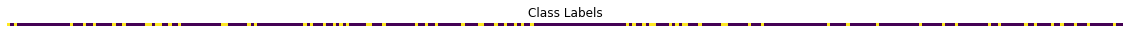

In [3]:
# Set data directory
rootDir = '/blue/camctrp/working/gullettj/ACT/derivatives/SVM/'
anatDir = '/blue/camctrp/working/gullettj/ACT/organized_data/';
funcDir = '/blue/camctrp/working/gullettj/ACT/derivatives/SVM/func/';
sdata = pd.read_csv(os.path.join(rootDir,'subjects_pre-mci_classification.csv')).to_numpy();
batch_size=17
im_size = (96,96,96)
# pat_size = (24,24,24)
grad_clip = 2
step_size = 1
gamma = 7e-1
seed = 42
samples_to_exclude = np.array([103744,106986,300142,101644,105903,106078,106817,101395,105554,204085])
exclude = np.equal(np.isin(sdata[:,0],samples_to_exclude),0);
num_cores = int(os.environ["SLURM_CPUS_PER_TASK"]);

# Two binary labels for Healthy vs pre-MCI
lab = np.array([sdata[:,1]]);
lab = lab[:,exclude]; 

class Diagnosis(Enum):
    normal = 0
    preMCI = 1
    
images = np.array([os.path.join(anatDir,''.join(['sub-',str(sdata[s,0])]),'ses-01','anat',''.join(['sub-',str(sdata[s,0]),'_ses-01_T1w.nii'])) for s in range(sdata.shape[0])]);
# images = np.array([os.path.join(rootDir,'anat',''.join(['wc0csub-',str(sdata[s,0]),'_ses-01_T1w.nii'])) for s in range(sdata.shape[0])]);
images = images[exclude]; 

# Plot Labels
plt.rcParams['figure.figsize'] = [20, 20]; plt.imshow(lab); 
plt.axis('off'); plt.title('Class Labels');

train case split:  114 : 232
valid case split:  6 : 27
test case split:  3 : 14 

sub-100161 (1/349) T1 Data
(176, 256, 256)


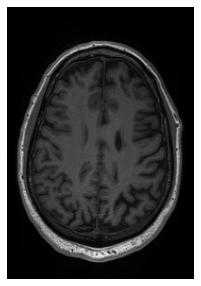

In [4]:
# def seed_everything(seed):
#     random.seed(seed)
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
#     torch.backends.cudnn.deterministic = True
    
# seed_everything(seed)    

nontest_list, test_list = train_test_split(images, 
                                          test_size=0.05,
                                          stratify=lab.T,
                                          random_state=seed)
nontest_label, test_label = train_test_split(lab.T, 
                                          test_size=0.05,
                                          stratify=lab.T,
                                          random_state=seed)
train_list, valid_list = train_test_split(nontest_list.T, 
                                          test_size=0.10,
                                          stratify=nontest_label,
                                          random_state=seed)
train_label, valid_label = train_test_split(nontest_label, 
                                          test_size=0.10,
                                          stratify=nontest_label,
                                          random_state=seed)
# Oversampling the Unbalnaced Class
train_list = np.array(np.hstack([[train_list.T],[train_list[train_label[:,0] == 1].T]]))[0,:];
train_label = np.array([np.int64(np.hstack([train_label[:,0],np.ones(sum(train_label[:,0] == 1))]))]).T;

print('train case split: ',sum(train_label)[0],':',len(train_label)-sum(train_label)[0])
print('valid case split: ',sum(valid_label)[0],':',len(valid_label)-sum(valid_label)[0])
print('test case split: ',sum(test_label)[0],':',len(test_label)-sum(test_label)[0],'\n')
del nontest_list, nontest_label; # Save RAM

# Plot Responder Mean
plt.rcParams['figure.figsize'] = [5,5];
np.disp(''.join(['sub-',str(sdata[0,0]),' (1/',str(sdata.shape[0]),') T1 Data']));
nii = nib.load(images[0]); print(nii.shape) # Load Each Electrode
plt.imshow(nii.get_fdata()[:, :, 120].T, cmap="gray", origin="lower"); plt.axis('off'); # Plot

torch.Size([1, 1, 96, 96, 96]) tensor([[[0, 1]]]) torch.Size([1, 1, 2])


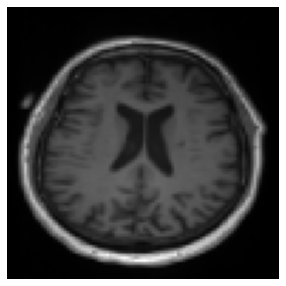

In [5]:
# Represent labels in one-hot format for binary classifier training,
# BCEWithLogitsLoss requires target to have same shape as input
labels = torch.nn.functional.one_hot(torch.as_tensor(lab.T)).long();
train_lab = torch.nn.functional.one_hot(torch.as_tensor(train_label.T)).long(); 
valid_lab = torch.nn.functional.one_hot(torch.as_tensor(valid_label.T)).long();
test_lab = torch.nn.functional.one_hot(torch.as_tensor(test_label.T)).long();

# Define transforms
train_transforms = Compose([
    ScaleIntensity(minv=0.0, maxv=1.0),
    AddChannel(),
    Resize(im_size),
#     RandBiasField(),
    RandGaussianNoise(), 
    EnsureType(data_type='tensor')]);

val_transforms = Compose([
    ScaleIntensity(minv=0.0, maxv=1.0),
    AddChannel(),
    Resize(im_size),
    EnsureType(data_type='tensor')]);

# Define nifti dataset, data loader
check_ds = ImageDataset(image_files=images, labels=labels, transform=train_transforms);
check_loader = DataLoader(check_ds, batch_size=1, num_workers=num_cores, pin_memory=pin_memory);

im, label = monai.utils.misc.first(check_loader); print(im.shape, label, label.shape)
plt.imshow(im[0,0,:,:,52].T, cmap="gray", origin="lower"); plt.axis('off'); del check_ds, check_loader, im, label;

# create a training data loader
train_ds = ImageDataset(image_files=train_list, labels=train_lab[0,:,:], transform=train_transforms);
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_cores, pin_memory=pin_memory);

# create a validation data loader
val_ds = ImageDataset(image_files=valid_list, labels=valid_lab[0,:,:], transform=val_transforms);
val_loader = DataLoader(val_ds, batch_size=batch_size, num_workers=num_cores, pin_memory=pin_memory)

In [ ]:
def save_model(n_epoch, save_path, run_id):
        lastmodel = f"{save_path}-e{n_epoch}-{run_id}.pth"
        torch.save(
            {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "best_valid_score": best_valid_score,
                "n_epoch": n_epoch,
            },
            lastmodel,
        )

# Create DenseNet121, CrossEntropyLoss and Adam optimizer
model = monai.networks.nets.DenseNet264(spatial_dims=3, in_channels=1, out_channels=2).to(device)

# Loss Function
bce = torch.nn.BCEWithLogitsLoss() 
def loss_fx(logits, target): 
    loss = bce(logits.view(-1), target.view(-1))
    return loss

lr = 1e-4
wd = 0

# start a typical PyTorch training
val_interval = 1
epoch_loss_values = [] # Pre-Allocate
epoch_acc_values = [] # Pre-Allocate
max_epochs = 100

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

wb.init(project="ACT-CNN",
           config={
               "batch_size": batch_size,
               "n_epoch": max_epochs,
               "image_size": im_size,
               "gradient_clip": grad_clip,
               "learning_rate": lr,
               "step_size": step_size,
               "network": "DenseNet264",
               "gamma": gamma,
               "weight_decay": wd,
               "dataset": "ACT",
           })
run_id = wb.run.name;
wb.watch(model, log='all')

scaler = torch.cuda.amp.GradScaler()
best_valid_score = 99999; # Initialize Loss
lastmodel = None
for epoch in range(max_epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for batch_data in train_loader:
        inputs, label = batch_data[0].to(device), batch_data[1].to(device);
        
        # Evaluate Model
        output = model(inputs);
        loss = loss_fx(output, label.float())
        
        # Update Gradient
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            # Evaluate Model
            output = model(inputs); epoch_prob = torch.nn.functional.softmax(output,dim=1)
            loss = loss_fx(output, label.float())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # Accuracy
        acc = (torch.nn.functional.softmax(epoch_prob,dim=1).argmax(dim=1) == label.argmax(dim=1)).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_acc_values.append(acc)
        
        # Loss
        epoch_loss += loss / len(train_loader)
        epoch_loss_values.append(epoch_loss)
        print(f"train loss: {loss.item():.4f}")
        wb.log({'train_loss': loss, 'train_acc': acc})

    if epoch % val_interval == 0: # Validation Interval
        with eval_mode(model):
            epoch_val_accuracy = 0; epoch_val_loss = 0;
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)

                val_output = model(val_images); val_prob = torch.nn.functional.softmax(val_output,dim=1);
                val_loss = loss_fx(val_output, val_labels.float())

                val_acc = (val_prob.argmax(dim=1) == val_labels.argmax(dim=1)).float().mean()
                epoch_val_accuracy += val_acc / len(val_loader)
                epoch_val_loss += val_loss / len(val_loader)
                wb.log({'val_loss': val_loss, 'val_acc': val_acc})
        print(
            f"Epoch : {epoch+1} - train_loss : {epoch_loss:.4f} - train_acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
        )
        
        # Save Best Model
        if best_valid_score > epoch_val_loss:
            print("model saved")
            save_model(epoch, "T1", run_id)
            best_valid_score = epoch_val_loss
            
    else:    
        print(
            f"Epoch : {epoch+1} - train_loss : {epoch_loss:.4f} - train_acc: {epoch_accuracy:.4f} \n"
        )
        
wb.run.log_code(root=os.path.join(os.getcwd(),"CNN.ipynb")); wb.finish()

train loss: 0.7361
train loss: 0.6990
train loss: 0.6630
train loss: 0.6331
train loss: 0.6685
train loss: 0.6502
train loss: 0.6848
train loss: 0.8445
train loss: 0.5951
train loss: 0.7190
train loss: 0.6726
train loss: 0.5888
train loss: 0.7882
train loss: 0.5954
train loss: 0.6179
train loss: 0.4573
train loss: 0.6570
train loss: 0.7204
train loss: 0.6070
train loss: 0.8746
train loss: 0.3914
Epoch : 1 - train_loss : 0.6602 - train_acc: 0.6275 - val_loss : 0.5626 - val_acc: 0.8199

model saved
train loss: 0.6267
train loss: 0.5812
train loss: 0.7381
train loss: 0.5861
train loss: 0.5286
train loss: 0.6390
train loss: 0.5325
train loss: 0.6222
train loss: 0.6020
train loss: 0.7434
train loss: 0.5604
train loss: 0.4162
train loss: 0.6878
train loss: 0.6516
train loss: 0.6247
train loss: 0.6308
train loss: 0.6546
train loss: 0.8499
train loss: 0.5079
train loss: 0.5680
train loss: 0.4171
Epoch : 2 - train_loss : 0.6080 - train_acc: 0.6835 - val_loss : 0.4989 - val_acc: 0.8199

model sa

# Test Model

In [ ]:
# model_files = [f'../input/monai3d-160-3ch-1e-5-20ep-aug/monai3d_160_3ch_1e-5_20ep_aug_best_fold{i}.pth' for i in range(1)]

# create a validation data loader
test_ds = ImageDataset(image_files=test_list, labels=test_lab[0,:,:], transform=val_transforms)
test_loader = DataLoader(test_ds, batch_size=batch_size, num_workers=num_cores, pin_memory=pin_memory)

with eval_mode(model):
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    test_acc = 0
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(
            device), test_data[1].to(device)

        outputs = model(test_images); probs = torch.nn.functional.softmax(outputs,dim=1);
        test_acc += (probs.argmax(dim=1) == test_labels.argmax(dim=1)).float().mean();
        y_pred = torch.cat([y_pred, probs.argmax(dim=1)], dim=0)
        y = torch.cat([y, test_labels.argmax(dim=1)], dim=0);
    test_acc = test_acc / len(test_loader)

print(classification_report(
    y.cpu().numpy(),
    y_pred.cpu().numpy(),
    target_names=[d.name for d in Diagnosis]))

cm = confusion_matrix(
    y.cpu().numpy(),
    y_pred.cpu().numpy(),
    normalize='true')

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[d.name for d in Diagnosis])

disp.plot(ax=plt.subplots(1, 1, facecolor='white')[1])

# Occulusion Sensitivity

In [ ]:
# cam = monai.visualize.CAM(nn_module=model_3d, target_layers="class_layers.relu", fc_layers="class_layers.out")
cam = monai.visualize.GradCAMpp(
    nn_module=model, target_layers="class_layers.relu"
)
# cam = monai.visualize.GradCAMpp(nn_module=model_3d, target_layers="class_layers.relu")
print(
    "original feature shape",
    cam.feature_map_size([1, 1] + list(im_size), device),
)
print("upsampled feature shape", [1, 1] + list(im_size))

occ_sens = monai.visualize.OcclusionSensitivity(
    nn_module=model, mask_size=12, n_batch=1, stride=24
)

# For occlusion sensitivity, inference must be run many times. Hence, we can use a
# bounding box to limit it to a 2D plane of interest (z=the_slice) where each of
# the arguments are the min and max for each of the dimensions (in this case CHWD).
the_slice = train_ds[0][0].shape[-1] // 2
occ_sens_b_box = [-1, -1, -1, -1, -1, -1, the_slice, the_slice]

train_transforms.set_random_state(42)
n_examples = 3
subplot_shape = [3, n_examples]
fig, axes = plt.subplots(*subplot_shape, figsize=(25, 15), facecolor="white")
items = np.random.choice(len(train_ds), size=len(train_ds), replace=False)

example = 0
for item in items:

    data = train_ds[
        item
    ]  # this fetches training data with random augmentations
    image, label = data[0].to(device).unsqueeze(0), data[1][1]
    y_pred = model(image); prob = torch.nn.functional.softmax(y_pred,dim=1);
    pred_label = prob.argmax(dim=1);
    
    # Only display preMCI
    if np.not_equal(label,1):
        continue

    img = image.detach().cpu().numpy()[..., the_slice]

    name = "actual: "
    name += "preMCI" if np.equal(label,1) else "healthy"
    name += "\npred: "
    name += "preMCI" if np.equal(pred_label.cpu().numpy(),1) else "healthy"
    name += f"\npreMCI: {prob[0,1]:.3}"
    name += f"\nhealthy: {prob[0,0]:.3}"

    # run CAM
    cam_result = cam(x=image, class_idx=None)
    cam_result = cam_result[..., the_slice]

    # run occlusion
    occ_result, _ = occ_sens(x=image, b_box=occ_sens_b_box)
    occ_result = occ_result[..., pred_label];

    for row, (im, title) in enumerate(
        zip(
            [img, cam_result, occ_result],
            [name, "CAM", "Occ. Sens."],
        )
    ):
        cmap = "gray" if np.equal(row,0) else "jet"
        ax = axes[row, example]
        if isinstance(im, torch.Tensor):
            im = im.cpu().detach()
        
        im_show = ax.imshow(np.squeeze(im[0][0].T), cmap=cmap, origin='lower')

        ax.set_title(title, fontsize=25)
        ax.axis("off")

    example += 1
    if example == n_examples:
        break